In [4]:
import os
import urllib
from pathlib import Path
import spiceypy as spice

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import datetime as dt
from surrender.geometry import look_at
from craterdetection.common.camera import Camera
from craterdetection.common.surrender import setup_renderer

_BASE_URL = 'https://naif.jpl.nasa.gov/pub/naif/'
_KERNEL_ROOT = Path('../data/spice_kernels')


def download_kernel(file_path, base_url=_BASE_URL, base_folder=_KERNEL_ROOT):
    if isinstance(file_path, str):
        file_path = Path(file_path)

    local_path = base_folder / file_path
    url = base_url + file_path.as_posix()

    # Create necessary sub-directories in the DL_PATH direction
    local_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        # If the file is not present in the download directory -> download it
        if not os.path.isfile(local_path):
            print(f"Downloading {url}", end="  ")
            # Download the file with the urllib  package
            urllib.request.urlretrieve(str(url), str(local_path))
            print("Done.")
        else:
            print(f"{base_folder / file_path} already exists!")
    except urllib.error.HTTPError as e:
        print(f"Error: \n{url} could not be found: ", e)

In [5]:
kernels_ = [
               'generic_kernels/lsk/naif0012.tls',
               'generic_kernels/pck/pck00010.tpc',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/spk/de421.bsp',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/pck/moon_pa_de421_1900_2050.bpc',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_assoc_pa.tf',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_080317.tf'
           ]
kernels = list(map(Path, kernels_))

for k in kernels:
    download_kernel(k)

spice.furnsh(list(map(lambda x: str(_KERNEL_ROOT / x), kernels)))

..\data\spice_kernels\generic_kernels\lsk\naif0012.tls already exists!
..\data\spice_kernels\generic_kernels\pck\pck00010.tpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\spk\de421.bsp already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\pck\moon_pa_de421_1900_2050.bpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_assoc_pa.tf already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_080317.tf already exists!


In [6]:
# Constants:
sun_radius = 696342000
earth_radius = 6371e3
ua2km = 149597870.700
ua = ua2km * 1e3
R_moon = 1737.4

s = setup_renderer()

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [7]:
s.createBRDF('sun', 'sun.brdf', {})
s.createShape('sun', 'sphere.shp', {'radius': sun_radius})
s.createBody('sun', 'sun', 'sun', [])

s.createBRDF("mate", "mate.brdf", {})
s.createShape("earth_shape", "sphere.shp", {'radius': earth_radius})
s.createBody("earth", "earth_shape", "mate", ["earth.jpg"])

s.createBRDF('hapke', 'hapke.brdf', {})
s.createSphericalDEM('moon', 'FullMoon.dem', 'hapke', 'lroc_color_poles.tiff')
s.setObjectElementBRDF('moon', 'moon', 'hapke')
s.setObjectAttitude('moon', np.array([0, 0, 0, 1]))

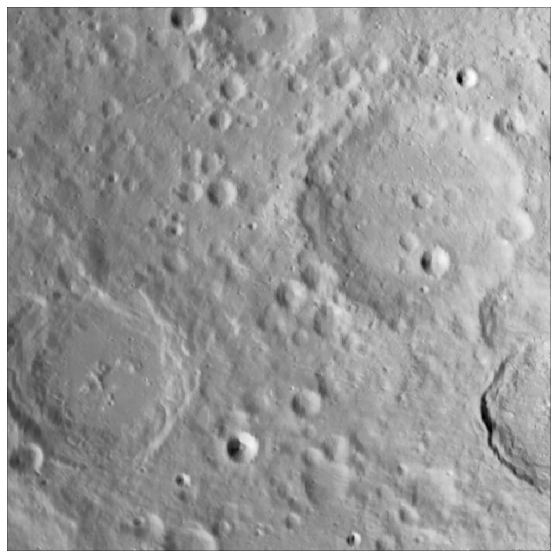

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

s.setObjectPosition('moon', (0, 0, 0))
cam = Camera.from_coordinates(14.47, -11.32, 300, convert_to_radians=True)
s.setObjectPosition('camera', cam.r.ravel()*1e3)
s.setObjectAttitude('camera', R.from_matrix(cam.T).as_quat())

# look_at(s, cam.r.ravel()*1e3, np.array([0, 0, 0])) # No north up?

for date in pd.date_range(dt.date(2021, 3, 3), periods=5, freq='8h'):
    # print(date.strftime('%Y %b %d %H:%M:%S'))
    et     = spice.str2et( str(date) )
    sun_pos, _ = spice.spkpos(
        'sun', et, 'iau_moon', 'lt+s', 'moon'
    )
    earth_pos, _ = spice.spkpos(
        'earth', et, 'iau_moon', 'lt+s', 'moon' )

    s.setObjectPosition('earth', earth_pos*1e3)
    s.setObjectPosition('sun', sun_pos*1e3)

    s.render()
    im = s.getImageGray32F()

    ax.imshow(im, aspect='equal', interpolation='none', cmap='Greys_r', origin='upper')
    ax.set_axis_off()
    display(fig)

    clear_output(wait=True)
    plt.pause(0.01)

In [9]:
s.getObjectAttitude('moon')


[0.0, 0.0, 0.0, 1.0]